# 적대적 생성 신경망으로 NMIST이미지를 생성

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras

In [2]:
# 실험을 재현하고 동일한 결과를 얻을 수 있는지 확인하기 위해 seed 를 설정합니다.
np.random.seed(10)

# 우리의 랜덤 노이즈 벡터의 차원을 설정합니다.
random_dim = 100

width = 28
height = 28

In [3]:
# 훈련셋과 시험셋 불러오기
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, width*height).astype('float32') / 255.0
x_test = x_test.reshape(10000, width*height).astype('float32') / 255.0

이제 Generator 및 Discriminatora 네트워크를 만들어 볼 수 있습니다. 두 네트워크에 모두 Adam Optimizer를 사용합니다. Generator와 Discriminator의 경우 모두 세 개의 숨겨진 레이어가 있는 신경 네트워크를 생성하며 활성화 함수는
 Leaky Relu를 사용합니다. 또한 Discriminator가 보이지 않는 영상에서 견고성을 향상시킬 수 있도록 Dropout(드롭아웃) 레이어를 추가해야 합니다.

## 생성자

먼저 벡터(훈련하는 동안 잠재 공간에서 무작위로 샘플링됩니다)를 후보 이미지로 변환하는 `generator` 모델을 만들어 보죠. GAN에서 발생하는 많은 문제 중 하나는 생성자가 노이즈 같은 이미지를 생성하는 데서 멈추는 것입니다. 판별자와 생성자 양쪽에 모두 드롭아웃을 사용하는 것이 해결 방법이 될 수 있습니다.

In [4]:
# Generator 만들기
input = keras.layers.Input(shape=(random_dim, ), dtype=tf.float32)
x = keras.layers.Dense(units=256,
                     kernel_initializer=keras.initializers.RandomNormal(stddev=0.02),
                     activation=keras.layers.LeakyReLU(0.2))(input)
x = keras.layers.Dense(units=512,
                     activation=keras.layers.LeakyReLU(0.2))(x)
x = keras.layers.Dense(units=1024,
                     activation=keras.layers.LeakyReLU(0.2))(x)
output = keras.layers.Dense(units=784, activation='tanh')(x)
generator = keras.models.Model(
    name='mnist_generator',
    inputs=input,
    outputs=output)
generator.summary()
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

Model: "mnist_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_3 (Dense)              (None, 784)               803600    
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
_________________________________________________________________


## 판별자

다음은 후보 이미지(진짜 혹은 가짜)를 입력으로 받고 두 개의 클래스로 분류하는 `discriminator` 모델을 만들겠습니다. 이 클래스의 입력은 '생성된 이미지' 또는 '훈련 세트에서 온 진짜 이미지'입니다.

In [5]:
# Discriminator 만들기
input = keras.layers.Input(shape=(784, ), dtype=tf.float32)

x = keras.layers.Dense(units=1024,
                     kernel_initializer=keras.initializers.RandomNormal(stddev=0.02),
                     activation=keras.layers.LeakyReLU(0.2))(input)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(units=512,
                     activation=keras.layers.LeakyReLU(0.2))(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(units=256,
                     activation=keras.layers.LeakyReLU(0.2))(x)
x = keras.layers.Dropout(0.3)(x)

output = keras.layers.Dense(units=1, activation='sigmoid')(x)
discriminator = keras.models.Model(
    name='mnist_discriminator',
    inputs=input,
    outputs=output)
discriminator.summary()
discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

Model: "mnist_discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)       

## 적대적 네트워크

마지막으로 생성자와 판별자를 연결하여 GAN을 설정합니다. 훈련할 때 생성자가 판별자를 속이는 능력이 커지도록 학습합니다. 이 모델은 잠재 공간의 포인트를 “진짜" 또는 “가짜"의 분류 결정으로 변환합니다. 훈련에 사용되는 타깃 레이블은 항상 '진짜 이미지'입니다. `gan`을 훈련하는 것은 `discriminator`가 가짜 이미지를 보았을 때 진짜라고 예측하도록 만들기 위해 `generator`의 가중치를 업데이트하는 것입니다. 훈련하는 동안 판별자를 동결(학습되지 않도록)하는 것이 아주 중요합니다. `gan`을 훈련할 때에는 판별자의 가중치가 업데이트되지 않습니다. 판별자의 가중치가 훈련하는 동안 업데이트되면 판별자는 항상 “진짜"를 예측하도록 훈련됩니다. 이것이 우리가 원하는 바는 아니죠!

In [6]:
# 판별자의 가중치가 훈련되지 않도록 설정합니다(gan 모델에만 적용됩니다)
discriminator.trainable = False

# GAN 입력(노이즈)은 위에서 100 차원으로 설정했습니다.
gan_input = keras.layers.Input(shape=(random_dim,), dtype=tf.float32)

# Generator의 결과는 이미지 입니다.
x = generator(gan_input)

# Discriminator의 결과는 이미지가 진짜인지 가짜인지에 대한 확률입니다.
gan_output = discriminator(x)

gan = keras.models.Model(name='mnist_gan', inputs=gan_input, outputs=gan_output)
gan.summary()
gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

Model: "mnist_gan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
mnist_generator (Functional) (None, 784)               1486352   
_________________________________________________________________
mnist_discriminator (Functio (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


이제 네트워크의 대부분을 코딩했습니다. 남은 것은 이 네트워크를 훈련하고 당신이 만든 이미지를 보는 것입니다.

In [7]:
batch_size = 128
epochs = 3
# train 데이터를 128 사이즈의 batch 로 나눕니다.
batch_count = x_train.shape[0] // batch_size

In [8]:
# 훈련 반복 시작
for e in range(1, epochs+1):
    print('-'*15, 'Epoch %d' % e, '-'*15)
    for _ in tqdm(range(batch_count)):
        # 입력으로 사용할 random 노이즈와 이미지를 가져옵니다.
        noise = np.random.normal(0, 1, size=[batch_size, random_dim])

        # MNIST 이미지를 생성합니다.
        generated_images = generator.predict(noise)

        # 훈련셋에서 랜덤하게 batch_size만큼의 데이터를 선택합니다.
        train_images = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

        # 판별자의 가중치가 훈련되도록 설정합니다
        discriminator.trainable = True
        # 판별자에게 가짜 이미지를 학습시킵니다.
        discriminator.train_on_batch(generated_images, np.zeros(batch_size, dtype=np.float32))
        # 판별자에게 진짜 이미지를 학습시킵니다.
        discriminator.train_on_batch(train_images, np.ones(batch_size, dtype=np.float32))

        # 입력으로 사용할 random 노이즈와 이미지를 가져옵니다.
        noise = np.random.normal(0, 1, size=[batch_size, random_dim])
        # 훈련에 사용되는 타깃 레이블은 항상 '진짜'입니다.
        y_gen = np.ones(batch_size)
        # 판별자의 가중치가 훈련되지 않도록 설정합니다
        discriminator.trainable = False
        # 적대적네트워크에서 생성자를 학습시킵니다.
        gan.train_on_batch(noise, y_gen)

  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 2 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 3 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:55<00:00,  4.05it/s]


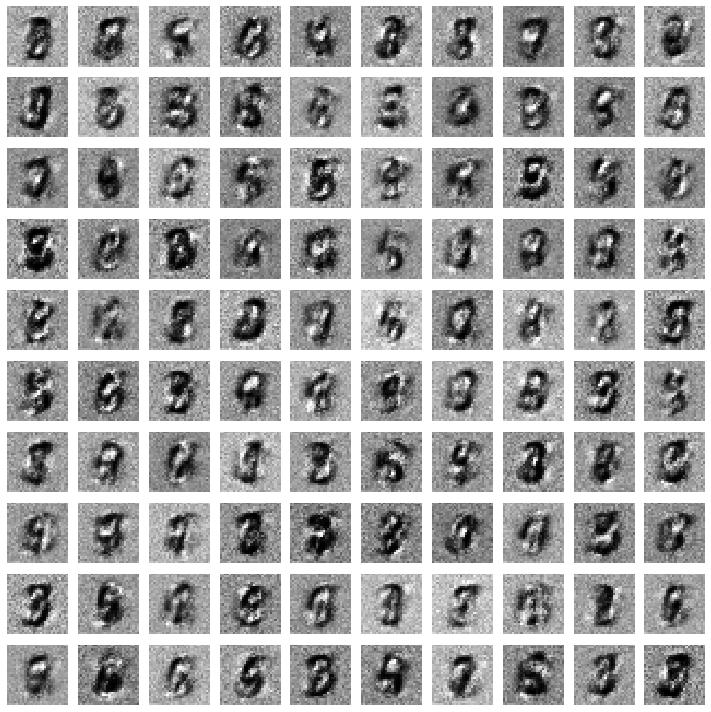

In [9]:
# 100개의 이미지를 생성합니다.
noise = np.random.normal(0, 1, size=[100, random_dim])
generated_images = generator.predict(noise)
generated_images = generated_images.reshape(100, 28, 28)

plt.figure(figsize=(10, 10))
for i in range(generated_images.shape[0]):
    plt.subplot(10, 10, i+1)
    plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()
plt.savefig('gan_generated_image.png')

400 epochs를 학습한 후 생성된 이미지를 보세요. 1 epoch 이후에 생성된 영상을 보면, 실제 구조가 없다는 것을 알 수 있습니다. 하지만 40 epochs 이후의 이미지를 보면, 숫자가 형성되기 시작하고 마지막으로, 400 epochs 후에 생성된 영상은 숫자가 뚜렷하게 나타납니다.